<a href="https://colab.research.google.com/github/ebramatef00/Classify-Song-Genres-from-Audio-Data/blob/main/Classify%20Song%20Genres%20from%20Audio%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [89]:
data=pd.read_csv("fma-rock-vs-hiphop.csv")
data.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [90]:
df=data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17734 entries, 0 to 17733
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       17734 non-null  int64 
 1   bit_rate       17734 non-null  int64 
 2   comments       17734 non-null  int64 
 3   composer       166 non-null    object
 4   date_created   17734 non-null  object
 5   date_recorded  1898 non-null   object
 6   duration       17734 non-null  int64 
 7   favorites      17734 non-null  int64 
 8   genre_top      17734 non-null  object
 9   genres         17734 non-null  object
 10  genres_all     17734 non-null  object
 11  information    482 non-null    object
 12  interest       17734 non-null  int64 
 13  language_code  4089 non-null   object
 14  license        17714 non-null  object
 15  listens        17734 non-null  int64 
 16  lyricist       53 non-null     object
 17  number         17734 non-null  int64 
 18  publisher      52 non-null

In [91]:
echonest_metrics = pd.read_json("echonest-metrics.json")

# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = echonest_metrics.merge(df[['track_id', 'genre_top']], on='track_id',)

# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [92]:
# check if there is quasi constant or dublicated or correlated
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,
)
# train and test
X_train, X_test, y_train, y_test = train_test_split(
    echo_tracks.drop(labels=['genre_top'], axis=1), # drop the target
    echo_tracks['genre_top'], # just the target
    test_size=0.3,
    random_state=0)

#pipeline
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # quasi constant feature
    ('duplicated', DropDuplicateFeatures()),
     ('correlation', SmartCorrelatedSelection(selection_method='variance')),
])
pipe.fit(X_train)

#apply pipeline
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

# Show features dropped
pipe.named_steps['constant'].features_to_drop_
pipe.named_steps['duplicated'].features_to_drop_

set()

Text(0.5, 1.0, 'Feature importance based on chi-square test')

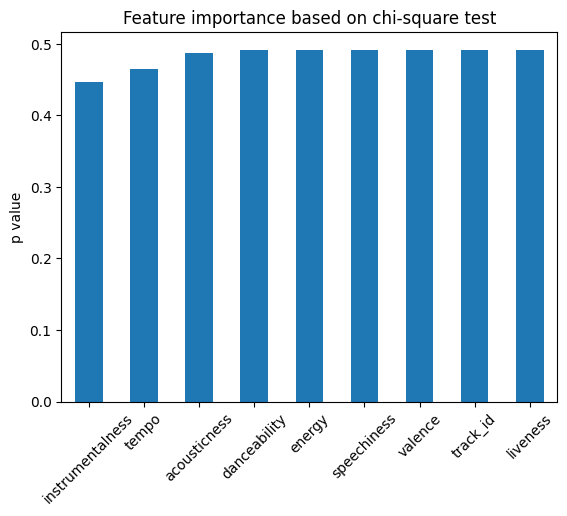

In [93]:
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split


# To rank all features
chi_ls = []
for feature in X_train.columns:

    # create contingency table
    c = pd.crosstab(y_train, X_train[feature])

    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

pd.Series(chi_ls, index=X_train.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')



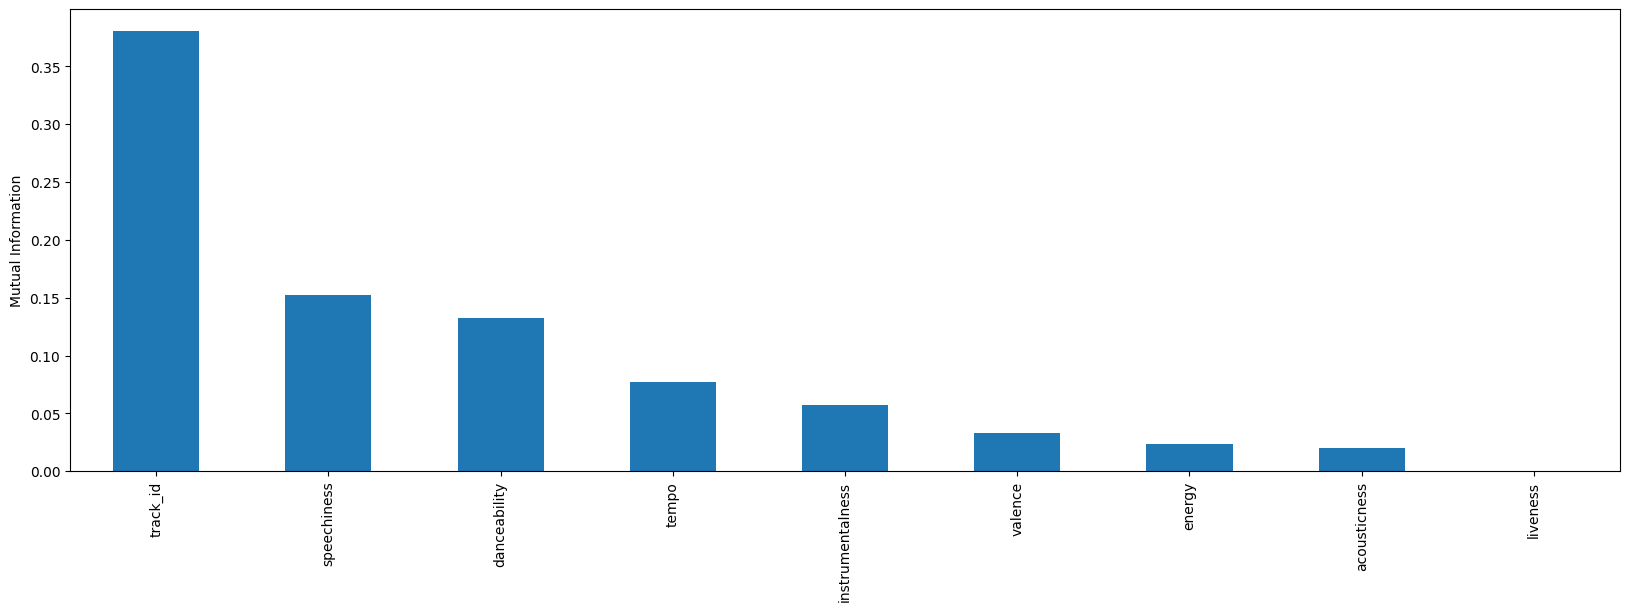

In [119]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import StandardScaler

# Scale the FEATURES ONLY and set the values to a new variable.
# The target variable should remain as string labels for classification.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit and transform the training data

#notes:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target
# determine the mutual information
mi = mutual_info_classif(X_train_scaled, y_train) # Use mutual_info_classif for classification tasks
# and make a bar  plot
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20,6))
plt.ylabel('Mutual Information')

# Select the features in the top percentile
sel_ = SelectPercentile(mutual_info_classif, percentile=40).fit(X_train_scaled, y_train) # Use mutual_info_classif

# display the features
X_train.columns[sel_.get_support()]
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(scaler.transform(X_test)) # Scale X_test using the same scaler

In [120]:
X_train_selected.shape

(3361, 4)

In [121]:
from sklearn import svm, ensemble, metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from enum import Enum

class Classifiers(Enum):
    svm = 0
    random_forest = 1
    decision_tree = 2
    adaboost = 3

class ClassifiersManager:
    def __init__(self):
        self.classifiers_names = {
            Classifiers.svm: "SVM",
            Classifiers.random_forest: "Random Forest",
            Classifiers.decision_tree: "Decision Tree",
            Classifiers.adaboost: "AdaBoost"
        }

        self.svm_classifier = svm.SVC()
        self.random_forest_classifier = ensemble.RandomForestClassifier()
        self.decision_tree_classifier = tree.DecisionTreeClassifier()
        self.adaboost_classifier = ensemble.AdaBoostClassifier()

        self.classifiers = {
            Classifiers.svm: self.svm_classifier,
            Classifiers.random_forest: self.random_forest_classifier,
            Classifiers.decision_tree: self.decision_tree_classifier,
            Classifiers.adaboost: self.adaboost_classifier,
        }

        self.classifiers_metrics = {}

    def train(self, classifier_enum, training_features, training_labels, hyperparameters=None):
        classifier = self.classifiers[classifier_enum]
        if hyperparameters:
            grid_search = GridSearchCV(classifier, hyperparameters, cv=5)
            grid_search.fit(training_features, training_labels)
            best_model = grid_search.best_estimator_
            self.classifiers[classifier_enum] = best_model
        else:
            classifier.fit(training_features, training_labels)


    def test(self, classifier_enum, testing_features, true_labels, target_names):
        predicted_labels = self.classifiers[classifier_enum].predict(testing_features)
        classification_rep = metrics.classification_report(true_labels, predicted_labels, target_names=target_names)
        accuracy = metrics.accuracy_score(true_labels, predicted_labels)
        # Add other metrics as needed
        return classification_rep, accuracy

    def train_all_classifiers(self, training_features, training_labels, hyperparameters=None):
        for classifier_enum in [Classifiers.svm, Classifiers.random_forest,Classifiers.adaboost,Classifiers.decision_tree]:
            self.train(classifier_enum, training_features, training_labels, hyperparameters)

    def test_all_classifiers(self, testing_features, true_labels, target_names):
        self.classifiers_metrics = {}
        for classifier_enum in [Classifiers.svm, Classifiers.random_forest,Classifiers.adaboost,Classifiers.decision_tree]:
            classification_rep, accuracy = self.test(classifier_enum, testing_features, true_labels, target_names)
            classifier_name = self.classifiers_names[classifier_enum]
            self.classifiers_metrics[classifier_name] = {'classification_report': classification_rep, 'accuracy': accuracy}
        return self.classifiers_metrics

    def print_metrics(self):
        for classifier, metrics in self.classifiers_metrics.items():
            print(classifier)
            print(metrics['classification_report'])
            print(f"Accuracy: {metrics['accuracy']}")


In [122]:
styles=['Rock', 'Hip-Hop']
classifiers_manager = ClassifiersManager()
classifiers_manager.train_all_classifiers(X_train_selected,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [123]:
classifiers_manager.test_all_classifiers(X_test_selected,y_test,styles)
classifiers_manager.print_metrics()


SVM
              precision    recall  f1-score   support

        Rock       0.78      0.68      0.72       279
     Hip-Hop       0.92      0.95      0.94      1162

    accuracy                           0.90      1441
   macro avg       0.85      0.82      0.83      1441
weighted avg       0.90      0.90      0.90      1441

Accuracy: 0.9000693962526024
Random Forest
              precision    recall  f1-score   support

        Rock       0.83      0.75      0.78       279
     Hip-Hop       0.94      0.96      0.95      1162

    accuracy                           0.92      1441
   macro avg       0.88      0.85      0.87      1441
weighted avg       0.92      0.92      0.92      1441

Accuracy: 0.9201943095072866
AdaBoost
              precision    recall  f1-score   support

        Rock       0.83      0.78      0.80       279
     Hip-Hop       0.95      0.96      0.95      1162

    accuracy                           0.93      1441
   macro avg       0.89      0.87      0.88